<h1 align="center" style="color:#0073e6;">PROTOCOLO DE TELEPORTACIÓN CUÁNTICA EN LA ESFERA DE BLOCH</h1> 

La **teleportación cuántica** consiste en transferir fielmente el estado de un único qubit entre dos partes, usualmente llamados **Alice** y **Bob**, empleando un par de qubits preparados en un **estado de Bell** (máximamente entrelazados) que ambos comparten (recurso compartido). 

En el protocolo reportado por *Bennett et al.*, Alice posee un estado cuántico 
$
\ket{\Psi} = \alpha\ket{0} + \beta\ket{1},
$
donde $\alpha$ y $\beta$ son amplitudes complejas **desconocidas para Alice**. 

Adicionalmente, Alice y Bob **comparten un estado de Bell**, el cual puede ser cualquiera de los cuatro estados maximámente entrelazados:

$$
\ket{\Phi^{+}}, \quad \ket{\Phi^{-}}, \quad \ket{\Psi^{+}}, \quad \text{o} \quad \ket{\Psi^{-}}.
$$

Los subíndices $A$ y $B$ indicarán los subsistemas correspondientes a Alice y Bob, respectivamente, es decir a quien pertenece cada qubit.


## Importar las librerías necesarias

In [755]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

## Desarrollo del protocolo

1) Se prepara un estado inicial para Alice $\ket{\Psi}$, el cúal se desea teleportar. El estado se define con un conjunto de parametros $\alpha, \beta$, donde se tiene en cuenta que es un estado normalizado y debe satsifacer $|\alpha|^2+|\beta|^2=1$.

In [756]:
# Escoja los valores para los parámetros del estado de Alice 

alpha = (0.5)**0.5
beta = (0.5)**0.5
parametros = [alpha, beta]

# Se crean los registros cuánticos y clásicos
qreg1 = QuantumRegister(size=1, name='Alice') 
qreg2 = QuantumRegister(size=1, name='Alice_entrelazado')
qreg3 = QuantumRegister(size=1, name='Bob_entrelazado')
creg = ClassicalRegister(size=2, name='Mediciones')

# Crear el circuito cuántico con 3 qubits y 2 bits clásicos
qc = QuantumCircuit(qreg1, qreg2, qreg3, creg)

# Inicializar el estado de Alice (qubit 0)
qc.initialize(parametros, qreg1)

# Obtener el vector de estado
state = Statevector.from_instruction(qc)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice"), index=0>, <Qubit register=(1, "Alice_entrelazado"), index=0>, <Qubit register=(1, "Bob_entrelazado"), index=0>), clbits=())

A continuación, se muestran los **estados iniciales de cada qubit** en el circuito.  
El **primer qubit** corresponde al **estado inicial de Alice**, que es el estado que se desea teleportar.  
Los **otros dos qubits** son los que **Alice y Bob compartiran** para formar el **estado de Bell**, estos qubits, por defecto, se inicializan en el estado $ \ket{0} $.


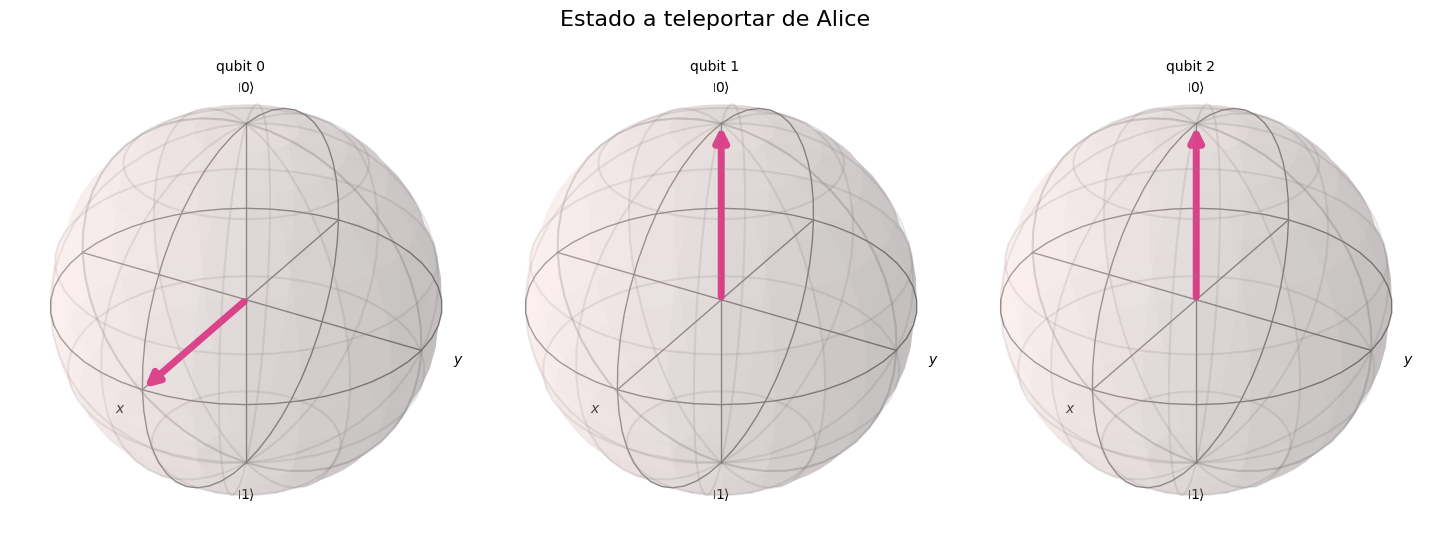

In [757]:
plot_bloch_multivector(state, title="Estado a teleportar de Alice")

2. Crear el **estado cuántico compuesto** de los tres qubits correspondientes a los subsistemas de Alice y Bob:  

$$
\ket{\Psi}_{A,B} = \ket{\Psi_{\text{inicial}}} \otimes \ket{\text{Bell}}.
$$


Para ello, se **entrelaza el segundo qubit de Alice con el de Bob**, formando así un **estado de Bell**, el cual puede ser cualquiera de los siguientes:


\begin{align*}
\ket{\Phi^{+}} &= \frac{1}{\sqrt{2}}(\ket{00} + \ket{11}), \\
\ket{\Phi^{-}} &= \frac{1}{\sqrt{2}}(\ket{00} - \ket{11}), \\
\ket{\Psi^{+}} &= \frac{1}{\sqrt{2}}(\ket{01} + \ket{10}), \\
\ket{\Psi^{-}} &= \frac{1}{\sqrt{2}}(\ket{01} - \ket{10}).
\end{align*}


Cada uno de estos estados puede usarse como recurso de entrelazamiento en el protocolo de teleportación.


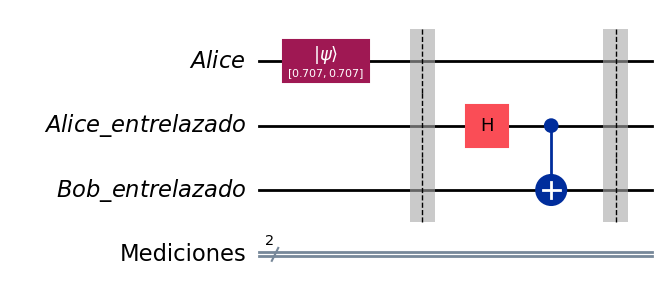

In [758]:
# Escoje y crea uno de los estados de Bell aplicando las compuertas necesarias

qc.h(1)
qc.cx(1, 2)

qc.barrier()
display(qc.draw(output='mpl'))

3. Alice debe **medir en la base de Bell** para colapsar el estado de los qubits de Bob.  

El objetivo de este paso es transformar la información cuántica contenida en el qubit inicial de Alice en **información clásica** (dos bits), que pueda ser enviada a Bob sin destruir la coherencia global del sistema.  

Medir directamente en la base computacional no sería suficiente, porque esa base no refleja las correlaciones cuánticas del entrelazamiento. Por ello, Alice debe **cambiar la base de medición** computacional $\{\ket{00}, \ket{01}, \ket{10}, \ket{11}\}$  a la **base de Bell**, compuesta por los cuatro estados maximálmente entrelazados:

$$
\{\ket{\Phi^{+}}, \ket{\Phi^{-}}, \ket{\Psi^{+}}, \ket{\Psi^{-}}\}.
$$

Para realizar esta medición en un circuito cuántico, se deben aplicar transformaciones unitarias que **rotan la base de Bell hacia la base computacional**.  
Esto se logra aplicando, en orden:

1. Una **compuerta CNOT**, donde el qubit del estado a teletransportar actúa como control y el segundo qubit de Alice como objetivo.  
2. Una **compuerta Hadamard** sobre el primer qubit (el que contenía el estado inicial de Alice).

Estas dos operaciones convierten la base de Bell en la base computacional, de modo que medir los dos qubits de Alice en la base estándar equivale a **medirlos en la base de Bell**.  

$$
\ket{\Psi}_{A,B} \xrightarrow{\text{CNOT, H}} \text{(superposición de los cuatro estados de Bell en la base computacional)}
$$

Dependiendo del **resultado de la medición** (00, 01, 10 o 11), el estado del qubit de Bob colapsará en una versión transformada del estado original de Alice.


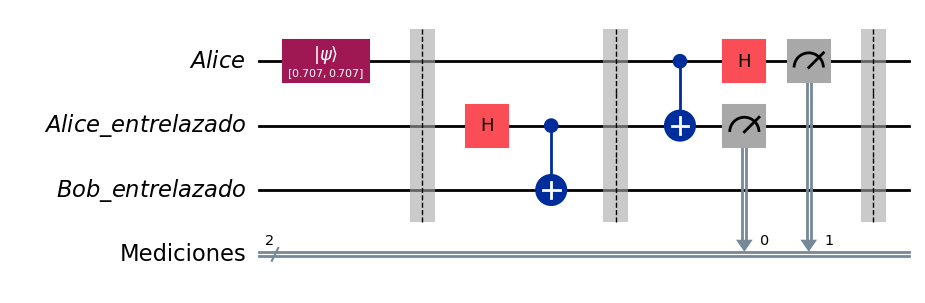

In [759]:
# Realiza la medición en la base de Bell y mide los qubits de Alice

qc.cx(0, 1)
qc.h(0)
qc.measure([1,0], [0,1])

qc.barrier()
display(qc.draw(output='mpl'))

4. Una vez Alice obtiene sus resultados y los comparte con Bob, él deberá aplicar las compuertas de Pauli `X` o `Z` correspondientes para **recuperar el estado inicial de Alice**.  

Los resultados de Alice determinan qué transformación sufrió el qubit de Bob tras el colapso. Cada combinación de resultados clásicos (dos bits) se asocia con una de las matrices de Pauli $\{I, X, Z, ZX\}$, que Bob debe aplicar para revertir esa transformación y obtener nuevamente:

$$
\ket{\Psi}_{\text{final}} = \alpha\ket{0} + \beta\ket{1}.
$$

En Qiskit, esto se implementa con **condicionales clásicos** mediante el comando `qc.if_test(qc.clbits[n], b)`, que permite aplicar una compuerta solo si el bit clásico $n$ de medición de Alice toma el valor $b$.

De forma general, según el **estado de Bell compartido** inicialmente, las correcciones que debe aplicar Bob son las siguientes:

| Estado compartido | Resultados de Alice (00, 01, 10, 11) → Operación de Bob |
|--------------------|-----------------------------------------------------------|
| $\ket{\Phi^{+}}$ | $(I, X, Z, ZX)$ |
| $\ket{\Phi^{-}}$ | $(Z, XZ, I, X)$ |
| $\ket{\Psi^{+}}$ | $(X, I, ZX, Z)$ |
| $\ket{\Psi^{-}}$ | $(XZ, Z, X, I)$ |

Estas correcciones garantizan que, sin importar qué estado de Bell se haya usado como recurso de entrelazamiento, Bob recupere exactamente el estado cuántico original de Alice.


In [760]:
# Si creg[1] == 1 -> aplicar (***) en Bob
with qc.if_test((creg[1], 1)):
    qc.z(2)

# Si creg[0] == 1 -> aplicar (***) en Bob
with qc.if_test((creg[0], 1)):
    qc.x(2)

# Almacenar el vector de estado antes de la medición final
qc.save_statevector()

5. Por último, debemos **simular el circuito cuántico**, para ello utilizamos el **Aer simulator** de Qiskit, que es un backend clásico diseñado para emular el comportamiento de circuitos cuánticos en un computador convencional. Este simulador permite ejecutar el circuito sin necesidad de un dispositivo cuántico real, obteniendo resultados ideales (sin ruido) o realistas (con modelos de ruido si se configuran).

El resultado de la medición de Alice en sus qubits fue: 00


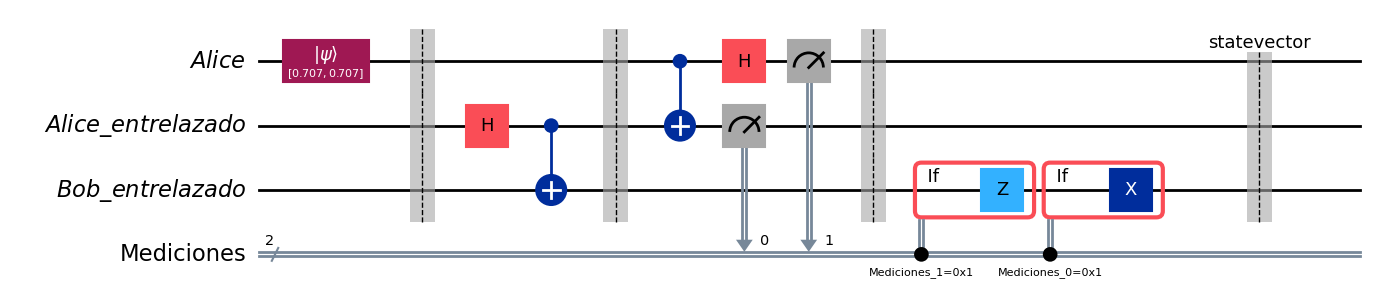

In [761]:
# Ejecutar el circuito
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)
job = simulator.run(circ, shots=1)
result = job.result()

# Obtener el resultado de las mediciones de Alice
alice = list(result.get_counts().keys())[0]  

# Obtener el vector de estado del circuito
statevector = result.data()['statevector']

print(f'El resultado de la medición de Alice en sus qubits fue: {alice}')
display(circ.draw(output='mpl'))

6. Finalmente, se representa el **estado final de Bob** en la **esfera de Bloch**.  
Observe que el estado final de Bob (qubit 2) coincide con el **estado inicial de Alice (qubit 0)** mostrado en el punto 1. Esto confirma que el **estado cuántico de Alice ha sido correctamente teleportado** a Bob. Mientras que los dos primeros qubits (de Alice) colapsan a estados clásicos tras la medición.

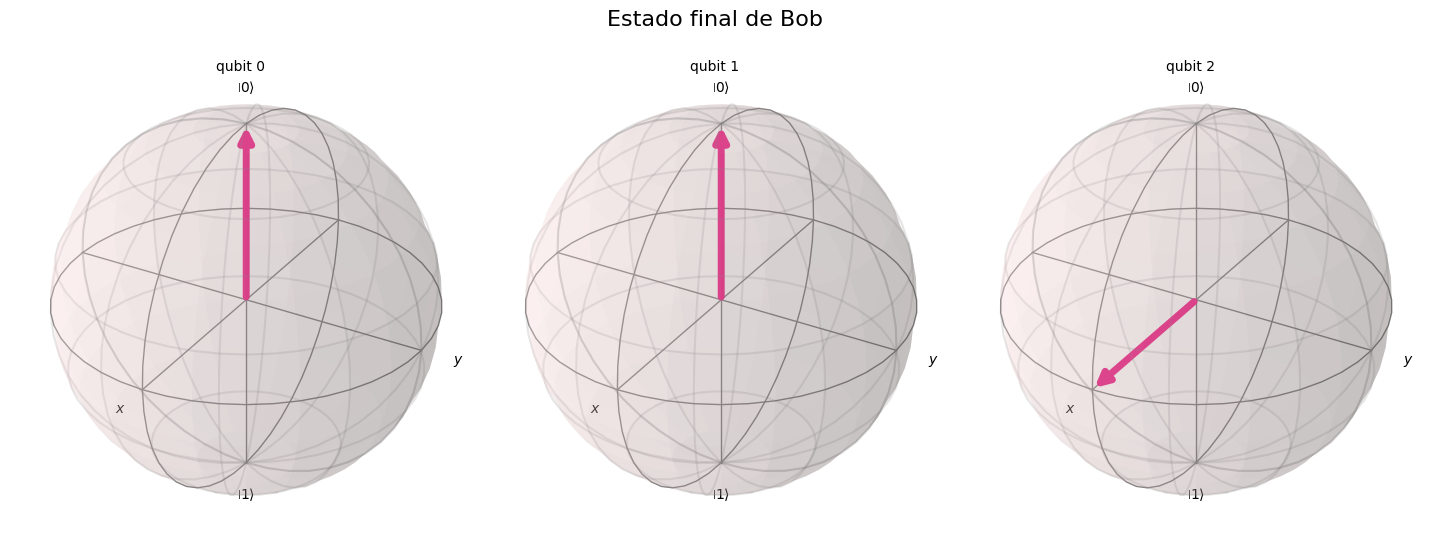

In [762]:
plot_bloch_multivector(statevector, title='Estado final de Bob')